## NCrystal materials in McStas

In this example we install McStas and Ncrystal using conda / mamba, and create a instrument simulation for a simple transmission beamline with a NCrystal sample.

## Preamble
Install dependencies and prepare plots. This installation is done with mamba to include both NCrystal and McStas. Feel free to edit as you wish:

In [1]:
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if google_colab:
    print("WARNING: Installing mambaforge. This will cause your notebook "
          "to say it crashed and restart itself. This is expected behaviour!!")
    %pip -q install condacolab
    import condacolab
    condacolab.install_mambaforge()
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
import pathlib
import os
import shutil
import subprocess
if not shutil.which('mcrun') or not shutil.which('nctool'):
    if not google_colab:
        raise RuntimeError('required dependencies not installed!')
    else:
      !mamba install mcstas-core ncrystal ipympl >/dev/null && echo installed mcstas-core and ncrystal
if 'MCSTAS' not in os.environ:
    _mcstasrd=subprocess.run(['mcrun','--showcfg=resourcedir'],
                              capture_output=True,check=True).stdout.decode().strip()
    os.environ['MCSTAS']=_mcstasrd
if google_colab:
    os.environ['CONDA_PREFIX']=str(pathlib.Path(shutil.which('nctool')).parent.parent)
mcstasdir=pathlib.Path(os.environ['MCSTAS'])
assert mcstasdir.is_dir(), "MCSTAS resource dir missing"
#enable inline and interactive matplotlib plots and import NCrystal:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009007, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


### Additional modules:

In [2]:
import os
import pathlib
import numpy as np
import shlex
import matplotlib.pyplot as plt

## Example

This cell writes the McStas instrument file. We write it this way because in Google Colab files are deleted when the runtime is regenerated.

We also define a few variables that will be used in the simulation.

In [3]:
beam_width = 0.01 # m
beam_height = 0.01 # m
sample_thickness = 0.01 # m
nbins = 700
sample_cfgstr = 'C_sg194_pyrolytic_graphite.ncmat;temp=20C'
NParticles = int(1e6)#number of neutrons to simulate
source_mon1_distance = 0.5 # m
mon1_sample_distance = 0.5 # m
sample_mon2_distance = 0.5 # m
min_lambda = 1.0
max_lambda = 8.0

txt = f'''/*
* Example instrument file (based on NCrystal_example.comp)
*
* It implements a simplistic steady-state source diffractometer
* with a Ge-511 monochromator and sample via NCrystal.
*
* The sample_cfg (string) parameter accepts an NCrystal cfg-string.
*/

DEFINE INSTRUMENT NCrystal_transm_example(string sample_cfg="Y2O3_sg206_Yttrium_Oxide.ncmat;density=0.6x")

DECLARE
%{{
%}}

INITIALIZE
%{{
%}}

TRACE

/* Example instrument in which two NCrystal_sample component instances are used
 to model respectively a Ge-511 monochromator and secondly an Yttrium-Oxide
 powder sample. Source and detectors are deliberately kept very simple.

 The orientation of the monochromator and the value of the central wavelength,
 lambda0, is set up in order for the neutrons at lambda0 to experience a 90 degree
 Bragg reflection (thetaBragg=45 degree) on the Ge511 plane, directing the reflected
 neutrons towards the sample (the d-spacing of Ge511 is 1.08876Aa):

           lambda = sin(45degree)*2*1.08876Aa = 1.539739Aa
*/

COMPONENT origin = Progress_bar()
  AT (0, 0, 0) RELATIVE ABSOLUTE

 COMPONENT source =   Source_gen(Lmin={min_lambda}, Lmax={max_lambda}, xwidth={beam_width}, yheight={beam_height}, focus_xw={beam_width}, focus_yh={beam_height}, dist=100)
   AT (0, 0, 0) RELATIVE origin

COMPONENT monitor1 = L_monitor(xmin={-beam_width/2}, xmax={beam_width/2}, ymin={-beam_height/2}, ymax={beam_height/2}, nL={nbins}, filename="monitor1.dat", Lmin={min_lambda},
                     Lmax={max_lambda},restore_neutron=1)
  AT (0, 0, {source_mon1_distance}) RELATIVE source

SPLIT COMPONENT powder_sample = NCrystal_sample(xwidth=10.0, yheight=10.0,zdepth={sample_thickness},
                                                cfg=sample_cfg)
 AT (0, 0, {mon1_sample_distance}) RELATIVE monitor1

COMPONENT monitor2 = L_monitor(xmin={-beam_width/2}, xmax={beam_width/2}, ymin={-beam_height/2}, ymax={beam_height/2}, nL={nbins}, filename="monitor2.dat", Lmin={min_lambda},
                     Lmax={max_lambda},restore_neutron=1)
  AT (0, 0, {sample_mon2_distance}) RELATIVE powder_sample

END
'''

instrument_file = pathlib.Path('./transmission_example.instr').absolute()
if not instrument_file.is_file() or txt!=instrument_file.read_text():
    instrument_file.write_text(txt)

Check the instrument file:

In [4]:
!cat {instrument_file}

/*
* Example instrument file (based on NCrystal_example.comp)
*
* It implements a simplistic steady-state source diffractometer
* with a Ge-511 monochromator and sample via NCrystal.
*
* The sample_cfg (string) parameter accepts an NCrystal cfg-string.
*/

DEFINE INSTRUMENT NCrystal_transm_example(string sample_cfg="Y2O3_sg206_Yttrium_Oxide.ncmat;density=0.6x")

DECLARE
%{
%}

INITIALIZE
%{
%}

TRACE

/* Example instrument in which two NCrystal_sample component instances are used
 to model respectively a Ge-511 monochromator and secondly an Yttrium-Oxide
 powder sample. Source and detectors are deliberately kept very simple.

 The orientation of the monochromator and the value of the central wavelength,
 lambda0, is set up in order for the neutrons at lambda0 to experience a 90 degree
 Bragg reflection (thetaBragg=45 degree) on the Ge511 plane, directing the reflected
 neutrons towards the sample (the d-spacing of Ge511 is 1.08876Aa):

           lambda = sin(45degree)*2*1.08876Aa = 1.

Now we run McStas:

In [5]:
outdir = pathlib.Path('./rundir')
shutil.rmtree(outdir,ignore_errors=True)
cfgstr_for_mcrun=shlex.quote(sample_cfgstr.replace(';',r'\;'))#quote for shell + workaround mcrun issues with semicolons.
!mcrun -c {instrument_file} sample_cfg={cfgstr_for_mcrun} -d {outdir} --ncount={NParticles}

INFO: Using directory: "rundir"
INFO: Regenerating c-file: transmission_example.c
Info:    'NCrystal_sample' is a contributed component.

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 
-> SPLIT N at component powder_sample

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:
Component powder_sample is NOACC, CPUONLY=1
-> FUNNEL mode enabled, SPLIT within buffer.
-> SPLIT within buffer at component powder_sample
-> GPU kernel from component monitor2

-----------------------------------------------------------
CFLAGS= -Wl,-rpath,CMD(ncrystal-config --show libdir) CMD(ncrystal-config --show libpath) -ICMD(ncrystal-config --show includedir) -DFUNNEL 
INFO: Recompiling: ./transmission_example.out
lto-wrapper: warning: using serial compilation of 2 LTRANS jobs
lto-wrapper: note: see the ]8;;https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html#index-flto'-flto' option d

Plot incident monitor

# Format: McCode with text headers
# URL: http://www.mccode.org
# Creator:  3.4.65, git
# Instrument: /some/where/transmission_example.instr
# Ncount: 1000000
# Trace: no
# Gravitation: no
# Seed: 1725347624021365
# Directory: rundir
# Param: sample_cfg=C_sg194_pyrolytic_graphite.ncmat;temp=20C
# Date: Tue Sep  3 09:13:46 2024 (1725347626)
# type: array_1d(700)
# Source: NCrystal_transm_example (/some/where/transmission_example.instr)
# component: monitor1
# position: 0 0 0.5
# title: Wavelength monitor
# Ncount: 1000000
# filename: monitor1.dat
# statistics: X0=4.49742; dX=2.02212;
# signal: Min=9.114e-11; Max=1.0801e-10; Mean=1e-10;
# values: 7e-08 7e-11 1e+06
# xvar: L
# yvar: (I,I_err)
# xlabel: Wavelength [AA]
# ylabel: Intensity
# xlimits: 1 8
# variables: L I I_err N
1.005 1.010099993e-10 2.65907877e-12 1443 
1.015 1.010099993e-10 2.65907877e-12 1443 
1.025 9.932999934e-11 2.636873131e-12 1419 


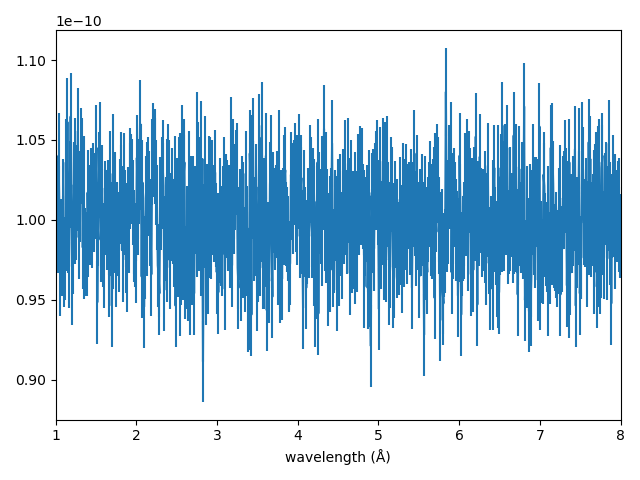

In [6]:
datafile = outdir / 'monitor1.dat'
assert datafile.exists(), "Monitor file not found"
!head -30 {datafile}

x=np.genfromtxt(datafile)
L, I, I_err, N = x.T

fig=plt.figure()
plt.errorbar(L,I,I_err)
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.show()

Plot transmission monitor

# Format: McCode with text headers
# URL: http://www.mccode.org
# Creator:  3.4.65, git
# Instrument: /some/where/transmission_example.instr
# Ncount: 1000000
# Trace: no
# Gravitation: no
# Seed: 1725347624021365
# Directory: rundir
# Param: sample_cfg=C_sg194_pyrolytic_graphite.ncmat;temp=20C
# Date: Tue Sep  3 09:13:46 2024 (1725347626)
# type: array_1d(700)
# Source: NCrystal_transm_example (/some/where/transmission_example.instr)
# component: monitor2
# position: 0 0 1.5
# title: Wavelength monitor
# Ncount: 1000000
# filename: monitor2.dat
# statistics: X0=4.75703; dX=2.09902;
# signal: Min=4.1407e-11; Max=1.04032e-10; Mean=6.5254e-11;
# values: 4.56778e-08 1.7872e-11 6.53225e+06
# xvar: L
# yvar: (I,I_err)
# xlabel: Wavelength [AA]
# ylabel: Intensity
# xlimits: 1 8
# variables: L I I_err N
1.005 5.772319804e-11 6.355885402e-13 8248 
1.015 5.799600869e-11 6.370880175e-13 8287 
1.025 5.770894603e-11 6.355086664e-13 8246 


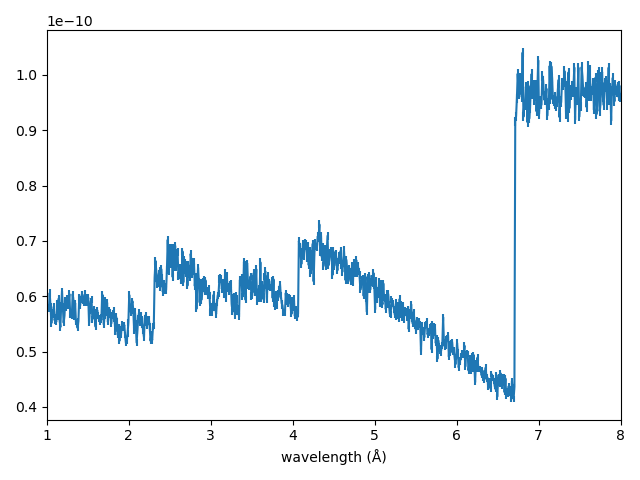

In [7]:
datafile = outdir / 'monitor2.dat'
assert datafile.exists(), "Monitor file not found"
!head -30 {datafile}

x=np.genfromtxt(datafile)
L2, I2, I2_err, N = x.T

fig=plt.figure()
plt.errorbar(L2,I2,I2_err)
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.show()

Plot transmission and compare with the theoretical (uncollided) transmission:

In [8]:
wl = np.linspace(min_lambda, max_lambda, 10000)
mat1 = NC.load(sample_cfgstr)
xs1 = mat1.scatter.xsect(wl=wl)+mat1.absorption.xsect(wl=wl)

N1 = mat1.info.getNumberDensity()

mat1.dump()


>>> Material info:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: C_sg194_pyrolytic_graphite.ncmat
----------------------------------------------------------------------------------------------------
Process cfg hints: lcaxis=0,0,1
----------------------------------------------------------------------------------------------------
Density : 2.26095 g/cm3, 0.11336 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% C
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% C
------------------------------------------------------------------------------------------

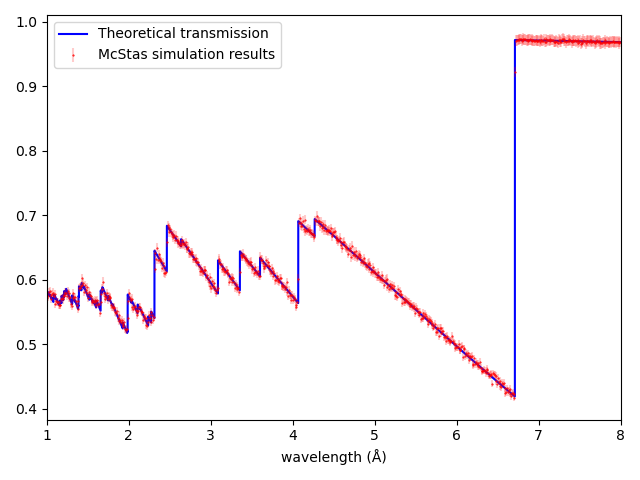

In [9]:
fig=plt.figure()
sample_thickness_cm = sample_thickness*100
plt.plot(wl, np.exp(-N1*xs1*sample_thickness_cm),
         color='b',
         label='Theoretical transmission')
plt.errorbar( L2, I2/I, I2_err/I, 
             color='r',ecolor=(1,0,0,0.2),fmt='.',markersize=1,
             label='McStas simulation results')
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.legend()
plt.show()

## Exercise

- Reduce the sample-detector distance to study the effect of in-scattering.
- Modify the material to see effects of changing temperature or density.

In [10]:
## Your code